# **Individual Coding Project Code**

- Student name: Aswin Subramanian Maheswaran

##  **Project Title**: 


### **Objectives:**
- 

### **Data sources:**

- 

#### **I. Setup the environment:**

In [1]:
# Install necessary packages
%pip install geopandas shapely pyproj tqdm plotly mapboxgl osmnx


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries

import random
import os
import zipfile
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, LineString
from shapely.ops import split
from shapely import affinity
from pyproj import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold


# Random seed

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
ox.settings.log_console = False
ox.settings.use_cache   = True


In [ ]:
# ---- spatial params ----

CRS_LONLAT  = "EPSG:4326"
CRS_METRIC  = "EPSG:3857"     # meters (for Spain)
COUNTRY_CODE = "ES"
FOCUS_BUF_M  = 1000           # 1 km focus window around GBIF points
MATCH_MAX_M  = 200            # max distance GBIF -> segment to count as a match
SEG_TARGET_M = 500            # ~500 m segment length
INTERSECT_NEAR_M = 250        # radius to count nearby endpoints

# ---- OSM fetch params ----
OSM_TILE_DIST_M = 7000        # download 7 km circles around tile centroids
ROUND_DEG = 0.1               # 11 km lat/lon rounding for GBIF tiling



## **Part 1: Building the dataset - GeoDataFrame**

###    1.1 Clean the GBIF dataset. 

In [ ]:
GBIF_FILEPATH = "data.csv"

GBIF_COLUMNS = [
    "gbifID","occurrenceID","countryCode",
    "decimalLatitude","decimalLongitude",
    "eventDate","year","month","day",
    "scientificName","basisOfRecord","coordinateUncertaintyInMeters"
]

road_kill = pd.read_csv(GBIF_FILEPATH, low_memory=False, sep='\t', on_bad_lines='skip')
road_kill = road_kill[[cols for cols in GBIF_COLUMNS if cols in road_kill.columns]].copy()


# a. basic parsing and filters

convert_to_numeric = lambda s: pd.to_numeric(s, errors="coerce")
road_kill["decimalLatitude"] = convert_to_numeric(road_kill["decimalLatitude"])
road_kill["decimalLongitude"] = convert_to_numeric(road_kill["decimalLongitude"])
road_kill["year"] = convert_to_numeric(road_kill["year"])
road_kill["month"] = convert_to_numeric(road_kill["month"])
road_kill["day"] = convert_to_numeric(road_kill["day"])

# b. Parse eventDate

road_kill["eventDate"] = pd.to_datetime(road_kill["eventDate"], errors="coerce")
fallback_date = pd.to_datetime(road_kill[["year", "month", "day"]], errors="coerce")
# fill the missing eventDate with fallback_date
road_kill["eventDate"] = road_kill["eventDate"].fillna(fallback_date)

# c. Filter by country code

filter_records = (
    
    (road_kill['countryCode'] == COUNTRY_CODE) &
    road_kill['decimalLatitude'].between(-90, 90) & road_kill['decimalLongitude'].between(-180, 180)
)

road_kill = road_kill[filter_records].dropna(subset=['decimalLatitude','decimalLongitude']).copy()

# d. Convert to GeoDataFrame and set CRS

road_kill_gdf = gpd.GeoDataFrame(
    road_kill, 
    geometry=gpd.points_from_xy(road_kill["decimalLongitude"], road_kill["decimalLatitude"]), 
    crs=CRS_LONLAT
).to_crs(CRS_METRIC)


print(f"GBIF's Spain records after cleaning: {len(road_kill_gdf)}")
print()
road_kill_gdf.head(2)

GBIF's Spain records after cleaning: 5050



,gbifID,occurrenceID,countryCode,decimalLatitude,decimalLongitude,eventDate,year,month,day,scientificName,basisOfRecord,coordinateUncertaintyInMeters,geometry
18,5100845320,060e8d29-0ad6-401d-a85f-97a0081d950c,ES,37.065452,-6.647498,2006-09-20,2006,9.0,20.0,"Pelobates cultripes (Cuvier, 1829)",HUMAN_OBSERVATION,30.0,POINT (-739996.092 4448233.883)
51,5100845353,985a81fc-6083-4429-bbbd-8bfcd09028e2,ES,37.356580,-6.341840,2011-04-09,2011,4.0,9.0,"Emberiza calandra Linnaeus, 1758",HUMAN_OBSERVATION,30.0,POINT (-705970.399 4488926.675)


####    **Insights into the data**

- **Challenge:** GBIF data is presence-only as it shows where animals were found dead, not where they weren't. This creates inherent bias.

    -   The absence data is missing, we don't know where animals were not found, only where they were. 
    -   Sampling bias, as observations are focused in locations with more activity (human activity and road infrastructure). 
    -   This bias must be taken into account when training the predictive model, as the absence of observations do not necessarily demonstrate low risk. 

- **Mitigate the challenge:** Define a focus window around observed points to restrict our analysis to areas with sufficient coverage, rather than extrapolating to unsampled regions. 

###    1.2 Focus-window and Area of Interest (AOI) 

**Aim**

-   Define a spatial boundary around the recorded roadkill locations to restrict the analysis area and reduce the presence-only bias effect. 
-   Buffer Distance is 1 kilometer surrounding all GBIF observation points. 
-   Focuses analysis on areas with known survey coverage, avoiding predictions in unsampled regions. 

**Method** (for computational efficiency):

-   **Tiling approach**: Round the coordinates to build 11 km tiles (ROUND_DEG = 0.1° ≈ 11 km at mid-latitudes)
-   **Tile-based buffering**: Create 1 km buffers around each unique tile centroid instead of each individual data point. 
-   In the end, I combine all the buffers into one continuous AOI shape. 

**Why this approach?**

- Much faster than buffering thousands of individual data points. 
- Reduces computational complexity from O(n) buffers to O(m) buffers where m << n (unique tiles)
- Produces a continuous study area suitable for road network extraction. 


[AOI] Focus window built (1 km around occupied tiles)


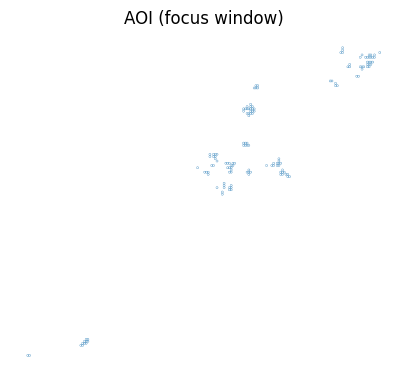

In [ ]:
# -------------     Build Area of Interest (AOI) - Focus Window     ------------------

# Convert all roadkill points to lat/lon coordinates

all_points = road_kill_gdf.to_crs(CRS_LONLAT).copy()

# Round coordinates to create spatial tiles (~11 km resolution)

all_points["lat_round"] = np.round(all_points.geometry.y / ROUND_DEG) * ROUND_DEG
all_points["lon_round"] = np.round(all_points.geometry.x / ROUND_DEG) * ROUND_DEG

# Extract unique tile centroids (one point per tile)

tiles = all_points[["lat_round","lon_round"]].drop_duplicates()
tile_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(tiles["lon_round"], tiles["lat_round"]),
    crs=CRS_LONLAT
).to_crs(CRS_METRIC)


# Create GeoDataFrame of tile centroids and convert to metric CRS

AOI = tile_points.buffer(FOCUS_BUF_M).union_all()
AOI_gdf = gpd.GeoDataFrame(geometry=[AOI], crs=CRS_METRIC)

# Buffer each tile centroid by 1 km and dissolve into single polygon
# union_all() merges overlapping buffers into one continuous AOI

print("[AOI] Focus window built (1 km around occupied tiles)")
AOI_gdf.boundary.plot(figsize=(5,5))
plt.title("AOI (focus window)")
plt.axis("off")
plt.show()


### 1.3 OSM roads inside the focus-window (tile-based)

**Aim**

-   Extract drivable road network data from OpenStreetMap (OSM) within the Area of Interest (AOI) to serve as the spatial framework for collision risk analysis.

**Road Classification**:

- Filtering only to major road types: `motorway`, `trunk`, `primary`, `secondary`, `tertiary`, `residential`
- These show the road hierarchy where most vehicle-wildlife collisions occur. 

**Data Quality**:
- I have noticed that it is common to have missing OSM tags. 
- Fill the missing values with defaults based on road class. 
- Clip the final roads to AOI boundary to remove edge artifacts from tile downloads. 

In [ ]:
#   -------     Download OSM Road Network (Tile-Based)  ----------

roads_list = []

# Iterating through each unique tile (from AOI creation step)

for _, row in tiles.iterrows():
    lat, lon = row["lat_round"], row["lon_round"]
    try:
        G = ox.graph_from_point((lat, lon), dist=OSM_TILE_DIST_M, network_type="drive")
        gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
        roads_list.append(gdf)
    except Exception as e:
        continue

roads = gpd.GeoDataFrame(pd.concat(roads_list, ignore_index=True), crs=CRS_LONLAT).to_crs(CRS_METRIC)

for col in ["highway","maxspeed","lanes","oneway","surface","bridge","tunnel"]:
    if col not in roads.columns:
        roads[col] = np.nan

def norm_highway(v):
    return v[0] if isinstance(v, list) else v

roads["highway_norm"] = roads["highway"].apply(norm_highway)
valid_classes = {"motorway","trunk","primary","secondary","tertiary","residential"}

roads = roads[roads["highway_norm"].isin(valid_classes)].copy()

# clip to AOI to drop margins
roads = gpd.overlay(roads, AOI_gdf, how="intersection")

# explode and clean
roads = roads.explode(index_parts=False, ignore_index=True)
roads = roads[~roads.geometry.is_empty & roads.geometry.notna()].copy()

print(f"[OSM] roads in AOI: {len(roads)}")
roads.sample(min(3, len(roads)))


KeyboardInterrupt: 

####    Handle missing OSM tags with safe defaults (helps later):

In [ ]:
# Default by highway class (tuned to Spanish norms)

DEFAULT_SPEED = {"motorway":120, "trunk":100, "primary":90, "secondary":80, "tertiary":60, "residential":30}
DEFAULT_LANES = {"motorway":2, "trunk":2, "primary":2, "secondary":1, "tertiary":1, "residential":1}

def parse_speed(x, cls):
    if isinstance(x, list) and len(x): x = x[0]
    if isinstance(x, str):
        num = "".join(ch for ch in x if ch.isdigit())
        x = int(num) if num else np.nan
    try:
        v = int(x)
        return v if 10 <= v <= 140 else DEFAULT_SPEED.get(cls, 50)
    except:
        return DEFAULT_SPEED.get(cls, 50)

def parse_lanes(x, cls):
    if isinstance(x, list) and len(x): x = x[0]
    try:
        v = int(x)
        return v if 1 <= v <= 6 else DEFAULT_LANES.get(cls, 1)
    except:
        return DEFAULT_LANES.get(cls, 1)

roads["maxspeed_kph"] = [parse_speed(x, c) for x, c in zip(roads["maxspeed"], roads["highway_norm"])]
roads["n_lanes"]      = [parse_lanes(x, c) for x, c in zip(roads["lanes"], roads["highway_norm"])]
roads["is_oneway"]    = roads["oneway"].astype("bool").fillna(False)


### 1.4 Segment Roads into 500 m Chunks

**Aim**
- Divide road network into uniform -500 m segments to create consistent analysis units for collision risk modeling.

**Why do we segment**
- It provides a fair comparison across different road types and identifies high-risk segments within longer roads. 

**Segment Features Calculated**:
-   segment_length_m (Actual measured length of each segment)
-   curve_index (Road curvature measure) : Higher values indicate sharper curves indicating potential collision hotspots. 
-   interaction_density (Count of nearby road endpoints per kilometer) : Gives insights into animal movement. 

